## Metrics for Python Model

In [ ]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

import pandas as pd
import numpy as np

# Assuming df is already loaded
y_true = df['true_label']
y_pred = df['predicted_label']
labels = np.unique(y_true)

# Micro and macro accuracy
micro_acc = accuracy_score(y_true, y_pred)
macro_acc = np.mean([
    (y_true[y_true == l] == y_pred[y_true == l]).mean()
    for l in labels
])

# Precision, Recall, F1 (macro average)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)


# AUC
y_true_bin = pd.get_dummies(y_true)
y_pred_bin = pd.get_dummies(y_pred).reindex(columns=y_true_bin.columns, fill_value=0)
auc_roc = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')

# Display
print(f"Micro Accuracy: {micro_acc:.4f}")
print(f"Macro Accuracy: {macro_acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Underestimated AUC-ROC (macro): {auc_roc:.4f}")

Micro Accuracy: 0.7939
Macro Accuracy: 0.7929
Precision (macro): 0.7824
Recall (macro): 0.7929
F1 Score (macro): 0.7797
Underestimated AUC-ROC (macro): 0.8421


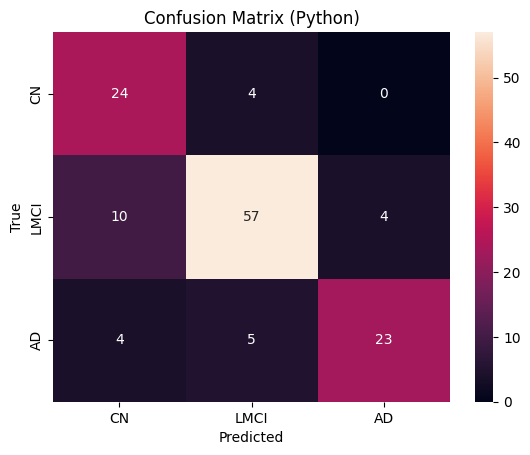

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(df['true_label'], df['predicted_label'], labels=['CN', 'LMCI', 'AD']), annot=True, fmt='d', xticklabels=['CN', 'LMCI', 'AD'], yticklabels=['CN', 'LMCI', 'AD'])
plt.title("Confusion Matrix (Python)")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

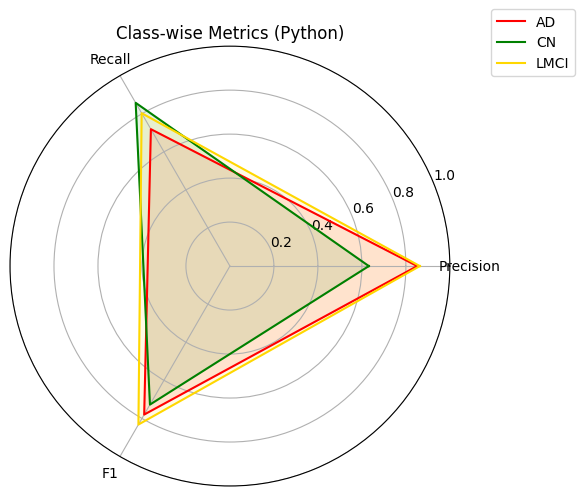

(array([0.85185185, 0.63157895, 0.86363636]),
 array([0.71875   , 0.85714286, 0.8028169 ]),
 array([0.77966102, 0.72727273, 0.83211679]))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

df = pd.read_csv("test_predictions_py.tsv", sep='\t')

# Get labels
labels = sorted(df['true_label'].unique())
y_true = df['true_label']
y_pred = df['predicted_label']

# Metrics per class
precision = precision_score(y_true, y_pred, average=None, labels=labels, zero_division=0)
recall = recall_score(y_true, y_pred, average=None, labels=labels, zero_division=0)
f1 = f1_score(y_true, y_pred, average=None, labels=labels, zero_division=0)

# Prepare radar chart data
metrics = ['Precision', 'Recall', 'F1']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# Colors for classes
color_map = {
    'CN': 'green',
    'LMCI': 'gold',
    'AD': 'red'
}

# Plot for each class
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, label in enumerate(labels):
    values = [precision[i], recall[i], f1[i]]
    values += values[:1]
    ax.plot(angles, values, label=label, color=color_map.get(label, 'gray'))
    ax.fill(angles, values, alpha=0.1, color=color_map.get(label, 'gray'))

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_title("Class-wise Metrics (Python)")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
precision, recall, f1

## Metrics for C++ Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# Read .tsv generated by cpp model (2-line records)
def read_cpp_predictions(path: str, n_classes: int = 3) -> pd.DataFrame:
    """
    Converte il TSV generato dal test C++ in un DataFrame piatto.
      • prima riga  = header delle feature (22 colonne)
      • seconda     = \tprob_CN … true_label	predicted_label
      • ogni sample = due righe (feature + righe prob./label)

    Restituisce colonne:
        [feature …] prob_CN prob_LMCI prob_AD true_label predicted_label
    """
    recs = []
    with open(path, "r", encoding="utf-8") as f:
        hdr_features = f.readline().rstrip("\r\n").split("\t")
        hdr_extra    = f.readline().rstrip("\r\n").split("\t")[1:]  # salta vuoto
        header = hdr_features + hdr_extra

        while True:
            l0 = f.readline()
            l1 = f.readline()
            if not l1: break                      # EOF
            vals0 = l0.rstrip("\r\n").split("\t")
            vals1 = l1.rstrip("\r\n").split("\t")[1:]  # salta cella vuota
            recs.append(vals0 + vals1)

    df = pd.DataFrame(recs, columns=header)

    # cast prob.* a float
    for c in range(n_classes):
        df[f"prob_class_{c}"] = df[f"prob_class_{c}"
                                   if f"prob_class_{c}" in df.columns
                                   else ["prob_CN","prob_LMCI","prob_AD"][c]].astype(float)

    return df

# Upload dataset
df = read_cpp_predictions("test_predictions_cpp.tsv")   # path al tuo TSV

# Label Mapping
label_map = {"CN": 0, "LMCI": 1, "AD": 2}
labels    = ["CN", "LMCI", "AD"]

y_true = df["true_label"].map(label_map)
y_pred = df["predicted_label"].map(label_map)

probs_cols = [f"prob_class_{i}" for i in range(len(labels))]
y_score = df[probs_cols].to_numpy()

# Metrics
micro_acc = accuracy_score(y_true, y_pred)
macro_acc = np.mean([
    (y_true[y_true == l] == y_pred[y_true == l]).mean()
    for l in range(len(labels))
])
precision  = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall     = recall_score   (y_true, y_pred, average="macro", zero_division=0)
f1         = f1_score       (y_true, y_pred, average="macro", zero_division=0)

print(f"Micro Accuracy   : {micro_acc:.4f}")
print(f"Macro Accuracy   : {macro_acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall    (macro): {recall:.4f}")
print(f"F1-score  (macro): {f1:.4f}")

# macro-AUC (one-vs-rest)
y_true_bin = label_binarize(y_true, classes=list(range(len(labels))))
auc_macro  = roc_auc_score(y_true_bin, y_score, average="macro", multi_class="ovr")
print(f"Macro-AUC (OvR)  : {auc_macro:.4f}")

# per-class / micro / macro ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(labels)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

Micro Accuracy   : 0.8015
Macro Accuracy   : 0.7630
Precision (macro): 0.8119
Recall    (macro): 0.7630
F1-score  (macro): 0.7831
Macro-AUC (OvR)  : 0.9172


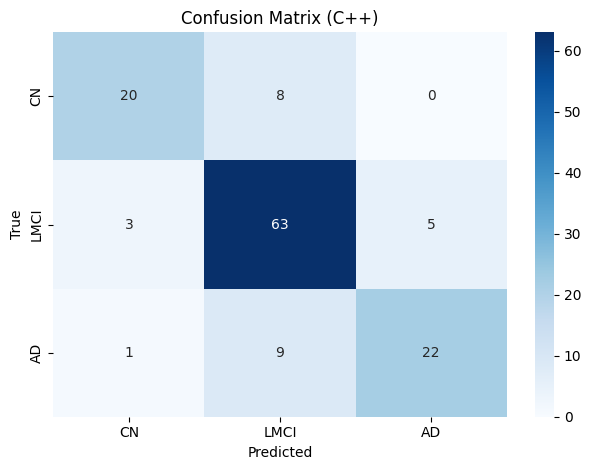

In [ ]:
# %% -------------------- confusion-matrix ---------------------------------
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
# plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (C++)")
plt.tight_layout(); plt.show()

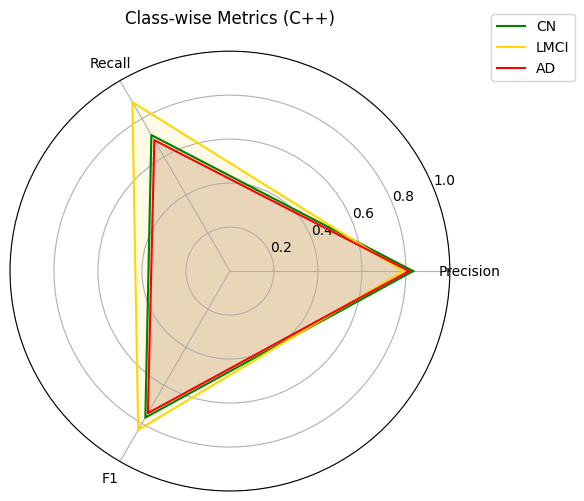

In [ ]:
# ------------------------------------------------------------
# Class-wise metrics – radar chart (C++)
# ------------------------------------------------------------
from math import pi

# Calcola precision, recall, F1 per ciascuna classe
precision = precision_score(y_true, y_pred,
                            average=None,
                            labels=list(label_map.values()),
                            zero_division=0)
recall = recall_score(y_true, y_pred,
                      average=None,
                      labels=list(label_map.values()),
                      zero_division=0)
f1 = f1_score(y_true, y_pred,
              average=None,
              labels=list(label_map.values()),
              zero_division=0)

# Etichette e metrica da plottare
metrics = ["Precision", "Recall", "F1"]
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]                       # chiude il poligono

# Colori per classe
color_map = {"CN": "green",
             "LMCI": "gold",
             "AD": "red"}

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for cls_idx, cls_name in enumerate(labels):
    vals = [precision[cls_idx], recall[cls_idx], f1[cls_idx]]
    vals += vals[:1]

    ax.plot(angles, vals,
            label=cls_name,
            color=color_map.get(cls_name, "gray"))
    ax.fill(angles, vals, alpha=0.10,
            color=color_map.get(cls_name, "gray"))

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_title("Class-wise Metrics (C++)", pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.30, 1.10))
plt.tight_layout()
plt.show()


## Instance vs Barch Normalization Macro-AUC for Python Model

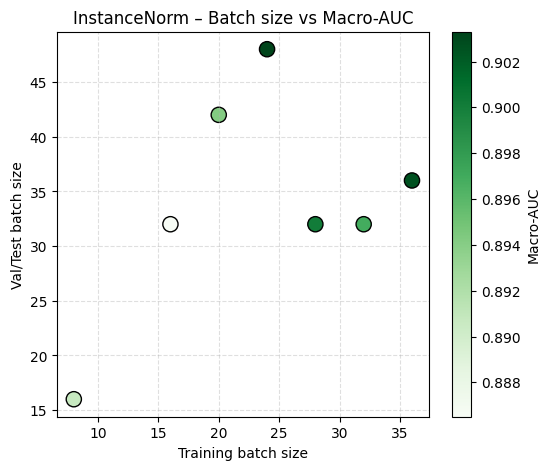

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Uploading Data
df = pd.read_csv("instance_auc_sp.csv")

# 2. Instance Normalization: Scatterplot of Batch Size vs Macro-AUC
plt.figure(figsize=(6,5))
sc = plt.scatter(df['train_bs'],
                 df['val_bs'],
                 c=df['macro_auc'],
                 cmap='Greens',
                 vmin=df['macro_auc'].min(),
                 vmax=df['macro_auc'].max(),
                 s=120, edgecolor='k')

plt.colorbar(sc, label='Macro-AUC')
plt.xlabel('Training batch size')
plt.ylabel('Val/Test batch size')
plt.title('InstanceNorm – Batch size vs Macro-AUC')
plt.grid(True, ls='--', alpha=.4)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


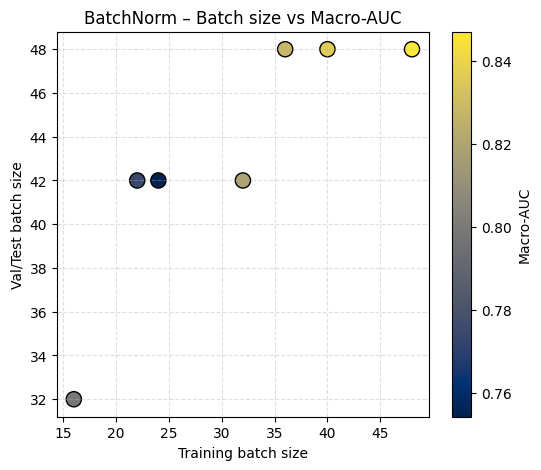

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Uploading Data
df = pd.read_csv("batch_auc_sp.csv")

# 2. Batch Normalization: Scatterplot of Batch Size vs Macro-AUC
plt.figure(figsize=(6,5))
sc = plt.scatter(df['Train_batch_size'],
                 df['Val_Test_batch_size'],
                 c=df['Macro_AUC'],
                 cmap='cividis',  # Colormap meno "positiva" del verde
                 vmin=df['Macro_AUC'].min(),
                 vmax=df['Macro_AUC'].max(),
                 s=120, edgecolor='k')

plt.colorbar(sc, label='Macro-AUC')
plt.xlabel('Training batch size')
plt.ylabel('Val/Test batch size')
plt.title('BatchNorm – Batch size vs Macro-AUC')
plt.grid(True, ls='--', alpha=.4)
plt.show()

## AUC-ROC (Python)

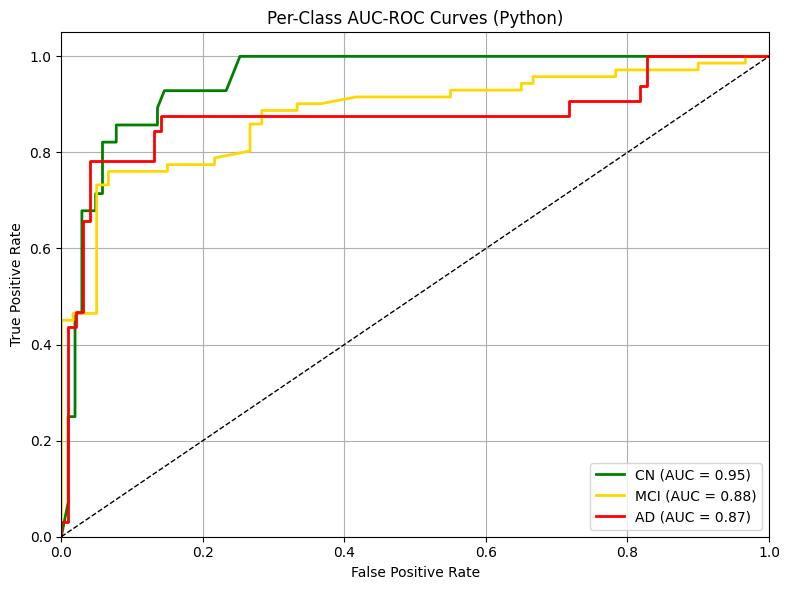

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Load predictions
df = pd.read_csv("test_predictions_py.tsv", sep='\t')

# Map true labels to class indices
label_map = {"CN": 0, "LMCI": 1, "AD": 2}
y_true = df['true_label'].map(label_map).values

# Extract probability scores for each class
y_score = df[['prob_class_0', 'prob_class_1', 'prob_class_2']].values

# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(8, 6))
colors = ['green', 'gold', 'red']
class_names = ['CN', 'MCI', 'AD']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Per-Class AUC-ROC Curves (Python)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


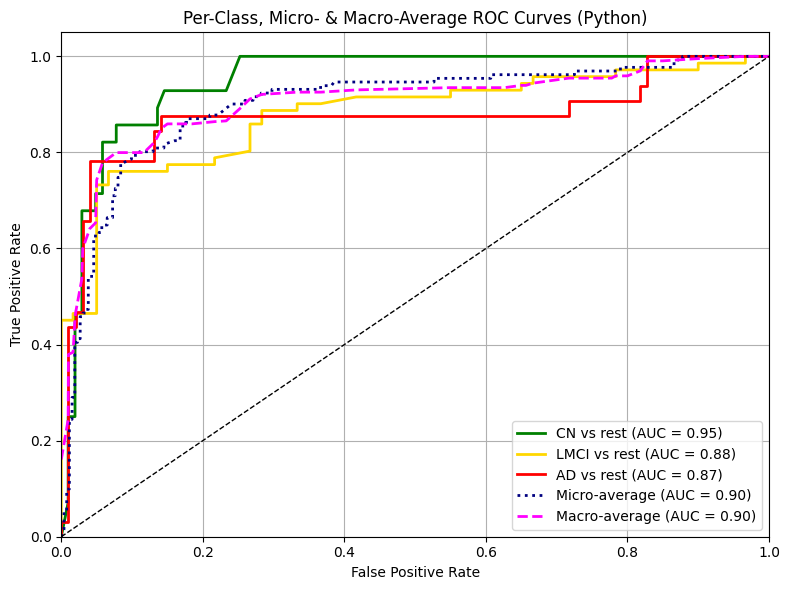

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Load predictions
df = pd.read_csv("test_predictions_py.tsv", sep='\t')

# Map true labels to class indices
label_map = {"CN": 0, "LMCI": 1, "AD": 2}
y_true = df['true_label'].map(label_map).values

# Extract probability scores for each class
y_score = df[['prob_class_0', 'prob_class_1', 'prob_class_2']].values

# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# 1) aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# 2) interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# 3) average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting
plt.figure(figsize=(8, 6))

# per-class
colors = ['green', 'gold', 'red']
class_names = ['CN', 'LMCI', 'AD']
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i],
        color=color, lw=2,
        label=f"{class_names[i]} vs rest (AUC = {roc_auc[i]:.2f})"
    )

# micro-average
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
    color='navy', linestyle=':', linewidth=2
)

# macro-average
plt.plot(
    fpr["macro"], tpr["macro"],
    label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
    color='magenta', linestyle='--', linewidth=2
)

# chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Per-Class, Micro- & Macro-Average ROC Curves (Python)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## AUC-ROC (C++)

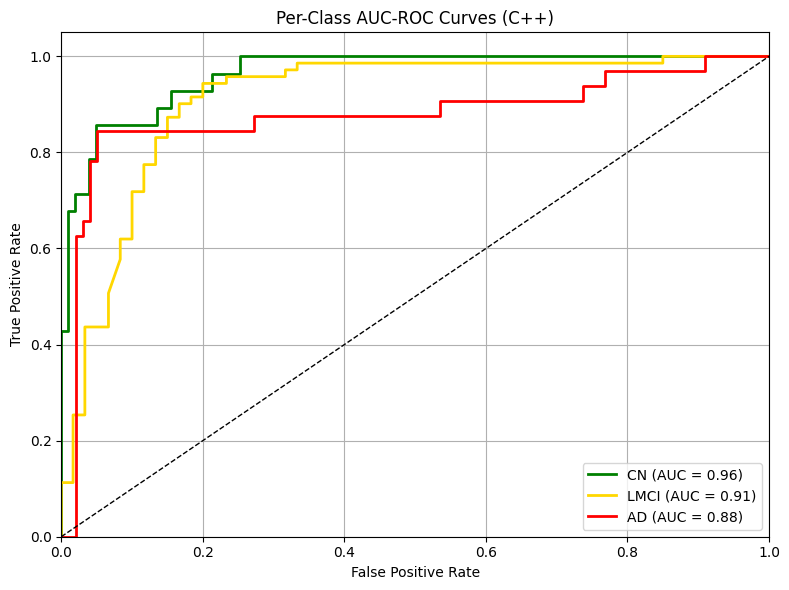

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def read_cpp_predictions(file_path):
    """
    Reads a TSV where:
      - The first two lines are headers:
          1) main feature names (22 columns),
          2) a second header with an empty first cell, then
             prob_CN, prob_LMCI, prob_AD, true_label, predicted_label.
      - Each sample spans two lines:
          line A = feature values (22 entries),
          line B = a leading tab + 5 entries (the 3 probs + true/pred labels).
    Returns a flat DataFrame.
    """
    records = []
    with open(file_path, 'r') as f:
        # Read and stitch together the two header rows
        header0 = next(f).rstrip('\n').split('\t')
        header1 = next(f).rstrip('\n').split('\t')[1:]  # skip the empty first cell
        columns = header0 + header1

        # Now read the data two lines at a time
        while True:
            try:
                line0 = next(f).rstrip('\n')
                line1 = next(f).rstrip('\n')
            except StopIteration:
                break
            vals0 = line0.split('\t')
            vals1 = line1.split('\t')[1:]  # skip leading empty field
            records.append(vals0 + vals1)

    df = pd.DataFrame(records, columns=columns)

    # Convert the probability columns to floats
    prob_cols = ['prob_CN', 'prob_LMCI', 'prob_AD']
    df[prob_cols] = df[prob_cols].astype(float)

    return df

# Load and parse your C++-style TSV
df = read_cpp_predictions("test_predictions_cpp.tsv")

# Map true labels to numeric indices
label_map = {"CN": 0, "LMCI": 1, "AD": 2}
y_true = df['true_label'].map(label_map).values

# Extract the per-class probability scores
y_score = df[['prob_CN', 'prob_LMCI', 'prob_AD']].values

# Binarize for multiclass ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(8, 6))
colors = ['green', 'gold', 'red']
class_names = ['CN', 'LMCI', 'AD']

for i in range(3):
    plt.plot(fpr[i], tpr[i],
             color=colors[i], lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Per-Class AUC-ROC Curves (C++)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

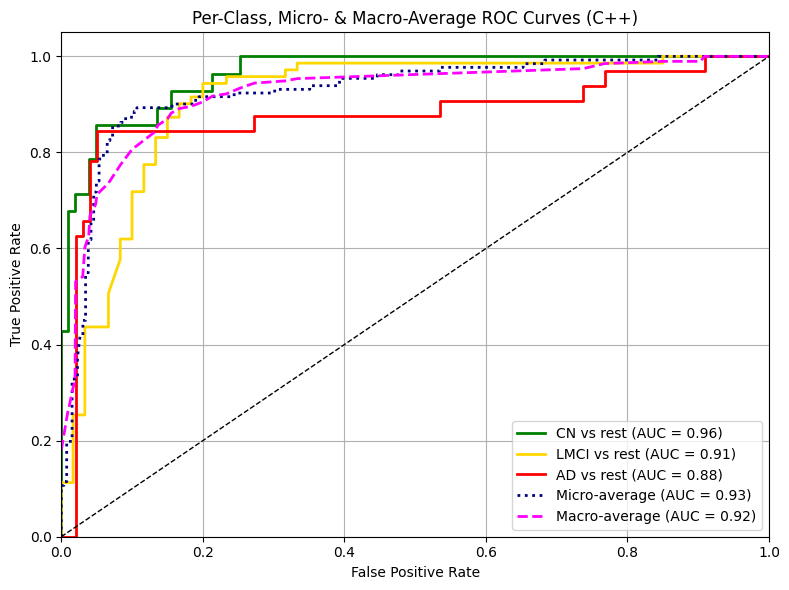

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def read_cpp_predictions(file_path):
    """
    Reads a TSV where:
      - The first two lines are headers:
          1) main feature names (22 columns),
          2) a second header with an empty first cell, then
             prob_CN, prob_LMCI, prob_AD, true_label, predicted_label.
      - Each sample spans two lines:
          line A = feature values (22 entries),
          line B = a leading tab + 5 entries (the 3 probs + true/pred labels).
    Returns a flat DataFrame.
    """
    records = []
    with open(file_path, 'r') as f:
        header0 = next(f).rstrip('\n').split('\t')
        header1 = next(f).rstrip('\n').split('\t')[1:]  # skip the empty first cell
        columns = header0 + header1

        while True:
            try:
                line0 = next(f).rstrip('\n')
                line1 = next(f).rstrip('\n')
            except StopIteration:
                break
            vals0 = line0.split('\t')
            vals1 = line1.split('\t')[1:]  # skip leading empty field
            records.append(vals0 + vals1)

    df = pd.DataFrame(records, columns=columns)
    # Convert the probability columns to floats
    prob_cols = ['prob_CN', 'prob_LMCI', 'prob_AD']
    df[prob_cols] = df[prob_cols].astype(float)
    return df

# --- load & prepare data ---
df = read_cpp_predictions("test_predictions_cpp.tsv")

label_map = {"CN": 0, "LMCI": 1, "AD": 2}
y_true = df['true_label'].map(label_map).values

y_score = df[['prob_CN', 'prob_LMCI', 'prob_AD']].values

y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# --- compute per-class ROC & AUC ---
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- micro-average ROC & AUC ---
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(),
    y_score.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- macro-average ROC & AUC ---
# 1) aggregate all false positive rates
all_fpr = np.unique(
    np.concatenate([fpr[i] for i in range(n_classes)])
)
# 2) interpolate each ROC at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# 3) average it
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- plotting ---
plt.figure(figsize=(8, 6))

# per-class
colors = ['green', 'gold', 'red']
class_names = ['CN', 'LMCI', 'AD']
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i],
        color=color, lw=2,
        label=f"{class_names[i]} vs rest (AUC = {roc_auc[i]:.2f})"
    )

# micro-average
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
    color='navy', linestyle=':', linewidth=2
)

# macro-average
plt.plot(
    fpr["macro"], tpr["macro"],
    label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
    color='magenta', linestyle='--', linewidth=2
)

# chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Per-Class, Micro- & Macro-Average ROC Curves (C++)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
